# Predicting the Opening Weekend Gross using Linear Regression Modeling

## Part 1 - Scraping & Parsing Movie Release Data

This is the first notebook as part of my project. It deals with Scraping & Parsing data from **www.boxofficemojo.com** and **www.imdb.com**.  
Movies released between 2010 and 2019 (inclusive) in US Market is scraped along with information on their US Release date & other relevant information. 

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import random
import time
import pickle
import sys
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sys.setrecursionlimit(50000)

### Scraping List of Movies
Box Office Mojo has movie releases for US Market listed in a table, by year.  
This information will be scraped for 2010 - 2019 and stored in a dictionery for further scraping of additional information on individual movie titles.

In [2]:
def scrape_movie_list_opening_weekend(year):
    """
    Scrapes the list of movies present in a table format in Box Office Mojo
    Checks if the required table data was retrieved from the website
    Returns the parsed HTML text for the table portion
    
    Input: Year
    Output: Tuple containing True or False. 
            if True, returns table rows in HTML format containing movie list.
            if False, returns Error message or reason for False
    """
     
    url = "https://www.boxofficemojo.com/year/{}/?sort=openingWeekendGross&grossesOption=totalGrosses"

# Gets data from Box Office Mojo. Checks if status code is not 200. If not 200, returns status code & False
# If status code 200, parses the text & looks for table, table row & movie title in second row, to confirm
# formatting is similar. If not, returns the same, else errors out.

    try:
        response = requests.get(url.format(year))
        if response.status_code != 200:
            return (False, "For year {} Got status code: {}".format(year,response.status_code))
        
        else:
            soup = BeautifulSoup(response.text, 'html5lib')
            
            try:
                movie_title = soup.find('div', id='table').find('tbody').find_all('tr')[1].find_all('td')[1].text
                if movie_title:
                    return (True, soup.find('div', id='table').find('tbody').find_all('tr')[1:])
                else:
                    return (False, "No movie title in second <tr> row. Different HTML formatting")
            except Exception as error_message:
                return (False, "Retrieving table/movie title gave following exception: {}".format(error_message))
            
    except Exception as error_message:
        return (False, "Error Somewhere in entire block with message: {}".format(error_message))

In [ ]:
#Loops through the years, scrapes Box Office Mojo & returns the result with True or Issue with False
 
all_movies_html = dict()

for year in range(2010,2020,1):
    all_movies_html[year] = scrape_movie_list_opening_weekend(year)
    time.sleep(.5+2*random.random())

The scraped movies are parsed for getting exact information and stored in a big dictionary.

In [5]:
# Helper functions

def currency_to_int(amount):
    """
    Converts a given curreny string to an integer
    For GBP currency, multiplies the value with 1.5 to convert to USD.
    All other international currencies are dropped.
    
    Input: amount --> '$123,562,324' or 'GBP54000'
    Output: Output --> 123562324 or 72900
    """
    try:
        if amount.startswith("GBP"):
            return int(int(amount.strip('GBP').replace(',',''))*1.5)
        elif amount.startswith("$"):
            return int(amount.strip('$').replace(',',''))
        else:
            return np.nan
    except :
        return np.nan

def percent_to_float(percentage):
    """
    Converts a given string percentage to float
    
    Input: 90.4%
    Ouput: 0.904
    """
    
    try:
        return float(percentage.strip('%-'))/100
    except:
        return np.nan

def runtime_to_minutes(runtimestring):
    """
    Take duration in string format & return in minute integer
    
    Input: 2 hrs 53 mins
    Output: 173
    """
    
    runtime = runtimestring.split()
    try:
        return int(int(runtime[0])*60 + int(runtime[2]))
    except:
        return np.nan

In [3]:
def HTML_table_row_to_dict(table_row_data):
    """
    Takes in table_row_data for a single table row in HTML syntax for Box Office Mojo 
    and returns a dictionary with necessary values 
    """
    
    temp_dict = dict()
    try:

        temp_dict['Release Link'] = "https://www.boxofficemojo.com/"+table_row_data[1].find('a').get('href')
        temp_dict['Title'] = table_row_data[1].text
        temp_dict['Domestic Gross'] = currency_to_int(table_row_data[5].text)
        temp_dict['Max Theatres'] = table_row_data[6].text.strip().replace(',','')
        temp_dict['Opening Weekend Gross'] = currency_to_int(table_row_data[7].text)
        temp_dict['Domestic to Opening Gross'] = percent_to_float(table_row_data[8].text)
        temp_dict['Opening Weekend Theatres'] = table_row_data[9].text.strip().replace(',','')
        temp_dict['Release Date'] = table_row_data[10].text + " "+str(year)
        temp_dict['Studio Link'] = table_row_data[12].find('a').get('href')
        temp_dict['Studio Name'] = table_row_data[12].text.strip()
    except Exception as ex:
        return (ex, temp_dict)

    return temp_dict

In [24]:
#Parsing the scraped information to store into neat columns

all_movies_clean = dict()
all_errors_clean = dict()

for year in range(2010,2020,1):
    
    if all_movies_html[year][0]:

        movies_log = list()
        error_log = list() 
        counter = 1

        for table_row in all_movies_html[year][1]:

            if table_row.find('td'):

                table_row_data = table_row.find_all('td')
                movie_info_clean = HTML_table_row_to_dict(table_row_data)
                
                if type(movie_info_clean) == dict:
                    movies_log.append(movie_info_clean)

                else:
        #             (counter, movie_info_clean[2]['Title'],len(movie_info_clean[2]),list(movie_info_clean[2])[-1])
#                     print(movie_info_clean)
                    movie_info_clean[1]['Counter'] = counter
                    movie_info_clean[1]['Error Message'] = movie_info_clean[0]
                    error_log.append(movie_info_clean[1])
                counter += 1
                
        all_movies_clean[year] = movies_log
        all_errors_clean[year] = error_log

In [15]:
#convert to dataframe & save as csv

df_list = pd.concat([pd.json_normalize(all_movies_clean[year]) for year in all_movies_clean],ignore_index=True)

df_list.to_csv('Scraped_Cleaned_MoviesList_2010-19.csv',index=False)

In [8]:
#reading the csv back into a dataframe that will be used for gathering more information

df_movies = pd.read_csv('Scraped_Cleaned_MoviesList_2010-19.csv',parse_dates=[8])

#modifying the dataframe
new_column_names_list = ['Title ID','Running Length','Budget','MPAA','Genre','Franchise Ranking','Brand Ranking']
df_movies = df_movies.reindex(df_movies.columns.tolist() + new_column_names_list,axis=1)

In [7]:
df_movies.head()

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise Ranking,Brand Ranking
0,https://www.boxofficemojo.com//release/rl15158...,Iron Man 2,312433331,4390,128122480,0.410,4380,May 7 2010,https://pro.imdb.com/company/co0023400/boxoffi...,Paramount Pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,https://www.boxofficemojo.com//release/rl12485...,Harry Potter and the Deathly Hallows: Part 1,295983305,4125,125017372,0.422,4125,Nov 19 2010,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,https://www.boxofficemojo.com//release/rl33932...,Alice in Wonderland,334191110,3739,116101023,0.347,3728,Mar 5 2010,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://www.boxofficemojo.com//release/rl13835...,Toy Story 3,415004880,4028,110307189,0.266,4028,Jun 18 2010,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://www.boxofficemojo.com//release/rl57771...,Shrek Forever After,238736787,4386,70838207,0.297,4359,May 21 2010,https://pro.imdb.com/company/co0040938/boxoffi...,DreamWorks,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Scraping Release Links

Each movie's page individual page in Box Office Mojo is scraped from the above table, to obtain additional information such as 'Title ID', 'Running Length', 'Budget', 'MPAA', 'Genre', 'Franchise', 'Brand'.

In [298]:
def scrape_release_links(url):
    """
    Function to scrape box office mojo's release page of a movie
    Confirm necessary information was retrieved & return HTML format page.
    
    Input: Release Link (url), that has to be queried
    Output: If successful, tutple containing (True,HTML Page)
            If not successful, tuple containing (False, Error message and if possible, the HTML page)
    """
    
    time.sleep(1+2*random.random())
    try: 
        
        response = requests.get(url)
        if response.status_code != 200:
            return (False,"Not able to get results from the page. Received status code {}" \
                    .format(response.status_code))
        
        else:
            soup_release = BeautifulSoup(response.text,'html5lib')
            
            try:
                summary_table = soup_release.find('div', class_='mojo-summary-values').find_all('div')
                assert len(summary_table) >= 1
                return (True,soup_release)
            except Exception as error_message:
                return (False,"Asserting summary table length gave following error: {}. \
                        \n Soup Results: \n {}".format(error_message,soup_release))
                
    except Exception as error_message:
        return (False,"Received error message from overall scraping. {}".format(error_message))
    
def clean_soup_release(soup_release):
    """
    Parse the HTML soup to return the Title ID, Budget, Running Time, MPAA Rating & Genre
    
    Input: HTML format page for Indivdiual Movies from Box Office Mojo
    Output: Tuple containing Title ID, Budget, Running Time, MPAA Rating & Genre
    """
    temp_movie_dict = dict()
    
    title = soup_release.find('h1', class_="a-size-extra-large").text    
    summary_table = soup_release.find('div', class_='mojo-summary-values')
    
    try:
        temp_movie_dict['title_id'] = soup_release.find('a', class_='mojo-title-link').get('href').split('/')[2]
    except Exception as error_message:
        print('Error getting title id for {}.\n. ERROR MESSAGE:'.format(title,error_message))
        temp_movie_dict['title_id'] = ''
        
    try:
        temp_movie_dict['Run Time'] = runtime_to_minutes(
                                      summary_table.find(text=re.compile("Running")).findNext().text)
    except Exception as error_message:
        print('Error getting Run Time for {}.\n. ERROR MESSAGE:'.format(title,error_message))
        temp_movie_dict['Run Time'] = np.nan
        
    try:        
        temp_movie_dict['Budget'] = currency_to_int(summary_table.find(text=re.compile("Budget")).findNext().text)
    except Exception as error_message:
        print('Error getting Budget for {}.\n. ERROR MESSAGE:'.format(title,error_message))
        temp_movie_dict['Budget'] = np.nan
        
    try:
        temp_movie_dict['MPAA'] = summary_table.find(text=re.compile("MPAA")).findNext().text.split()
    except Exception as error_message:
        print('Error getting MPAA for {}.\n. ERROR MESSAGE:'.format(title,error_message))
        temp_movie_dict['MPAA'] = np.nan
    
    try:
        temp_movie_dict['Genre'] = summary_table.find(text=re.compile("Genre")).findNext().text.split()
    except Exception as error_message:
        print('Error getting Genres for {}.\n. ERROR MESSAGE:'.format(title,error_message))
        temp_movie_dict['Genre'] = np.nan
    
    temp_movie_dict['Franchise Ranking'] = 1 if soup_release.find(text=re.compile("Franchise rankings")) else 0
    temp_movie_dict['Brand Ranking'] = 1 if soup_release.find(text=re.compile("Brand rankings")) else 0
    
    return temp_movie_dict


In [27]:
#scraping the individual movies' release page

for row_index,row_series in df_movies.iloc[:,:].iterrows():
    release_link = row_series['Release Link']
    
    soup_release = scrape_release_links(release_link)
    if soup_release[0]:
        movie_details = clean_soup_release(soup_release[1])
        
        print(row_series['Title'])
        print(movie_details)
        
        df_movies.loc[row_index, new_column_names_list] = movie_details.values()
        
    else:
        print("Error scraping the link or finding the table")
        print(soup_release[1])
        input()
    
    
    
    if row_index+1%25 == 0:
        df_movies.to_csv("Movies_listv2.csv",index=False)
        time.sleep(20+5*random.random())
        
df_movies.to_csv("Movies_listv2.csv",index=False)

### Cleaning the dataframe 

1. Movie releases that were Re-releases, Special Editions, Remixes or Extended Cut were dropped from the dataset.

In [11]:
df_movies = pd.read_csv('Movies_listv2.csv')

df_movies.shape

(6699, 17)

In [12]:
df_movies_to_drop = df_movies[df_movies.Title.str.contains("Re-release|special edition|remix|extended|: live",case=False,regex=True)]
# print(df_movies_to_drop.shape)
df_movies_to_drop.shape

(419, 17)

In [13]:
# Dropping 419 rows from the dataset due to the above described criteria.
df_movies = df_movies.drop(labels=df_movies_to_drop.index,axis=0).reset_index(drop=True)
df_movies.shape

(6280, 17)

2. Checking for blank values & making a decision on what to do with them

In [17]:
# Checking overall number of blank values

df_movies[df_movies.isnull().any(axis=1)].shape

(5086, 17)

**Since there are a lot of blank values, columns will be checked invididually**

In [18]:
# Checking for blank values only in Brank Ranking & Franchinse Ranking

df_movies[df_movies.loc[:,['Brand Ranking','Franchise Ranking']].isnull().any(axis=1)]

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise Ranking,Brand Ranking
879,https://www.boxofficemojo.com//release/rl15165...,My Reincarnation,92822,5,6498,0.07,1,Oct 28 2011,https://pro.imdb.com/company/co0358991/boxoffi...,Long Shot Factory,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [304]:
#With only a single missing value, the values were filled by calling the scraping & cleaning functions

soup_release = scrape_release_links("https://www.boxofficemojo.com/release/rl1516537345/weekend/")
if soup_release[0]:
    movie_details = clean_soup_release(soup_release[1])
    df_movies.loc[879, new_column_names_list] = movie_details.values()

else:
    print("Error scraping the link or finding the table")
    print(soup_release[1])

df_movies[df_movies.loc[:,['Brand Ranking','Franchise Ranking']].isnull().any(axis=1)]

Error getting Budget for My Reincarnation.
. ERROR MESSAGE:
Error getting MPAA for My Reincarnation.
. ERROR MESSAGE:


,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise Ranking,Brand Ranking


In [19]:
print(df_movies[df_movies.loc[:,['Title ID']].isnull().any(axis=1)].shape)

# No values missing from Title

(21, 17)


In [20]:
# df_movies['Genre'] = df_movies['Genre'].map(lambda x: np.nan if len(x) == 0 else x)
# Earlier soup code was filling in blank list for Genre when Genre could not be retrieved. 
# Above code changed empty lists to nan values

print(df_movies.MPAA.isnull().sum())
print(df_movies.Genre.isnull().sum())
print(df_movies.Budget.isnull().sum())

2953
1
5019


At present, only **Budget** values will be added; since it is judged to be an important criterian for predicting the opening weekend gross.

In [21]:
null_values_mask = (df_movies.Budget.isnull())
df_movies[null_values_mask].shape

(5019, 17)


### Exploring the Values

Before retrieving the missing values for the above dataframe, plotting the gross values to see if there any patterns & if the rows can be cut further

In [22]:
df_movies.describe()

,Domestic Gross,Opening Weekend Gross,Domestic to Opening Gross,Running Length,Budget,Franchise Ranking,Brand Ranking
count,6.280000e+03,6.280000e+03,6280.000000,6097.000000,1.261000e+03,6279.000000,6279.000000
mean,1.727190e+07,5.205487e+06,0.283905,105.556011,5.450587e+07,0.067845,0.064341
std,5.493935e+07,1.787751e+07,0.236398,30.446112,5.672030e+07,0.251500,0.245380
min,7.200000e+01,0.000000e+00,0.000000,61.000000,2.000000e+03,0.000000,0.000000
25%,2.502400e+04,4.755500e+03,0.074000,91.000000,1.500000e+07,0.000000,0.000000
50%,1.841175e+05,2.409600e+04,0.259000,101.000000,3.500000e+07,0.000000,0.000000
75%,3.705458e+06,5.050545e+05,0.430000,114.000000,7.500000e+07,0.000000,0.000000
max,9.366622e+08,3.571150e+08,1.891000,1179.000000,3.560000e+08,1.000000,1.000000


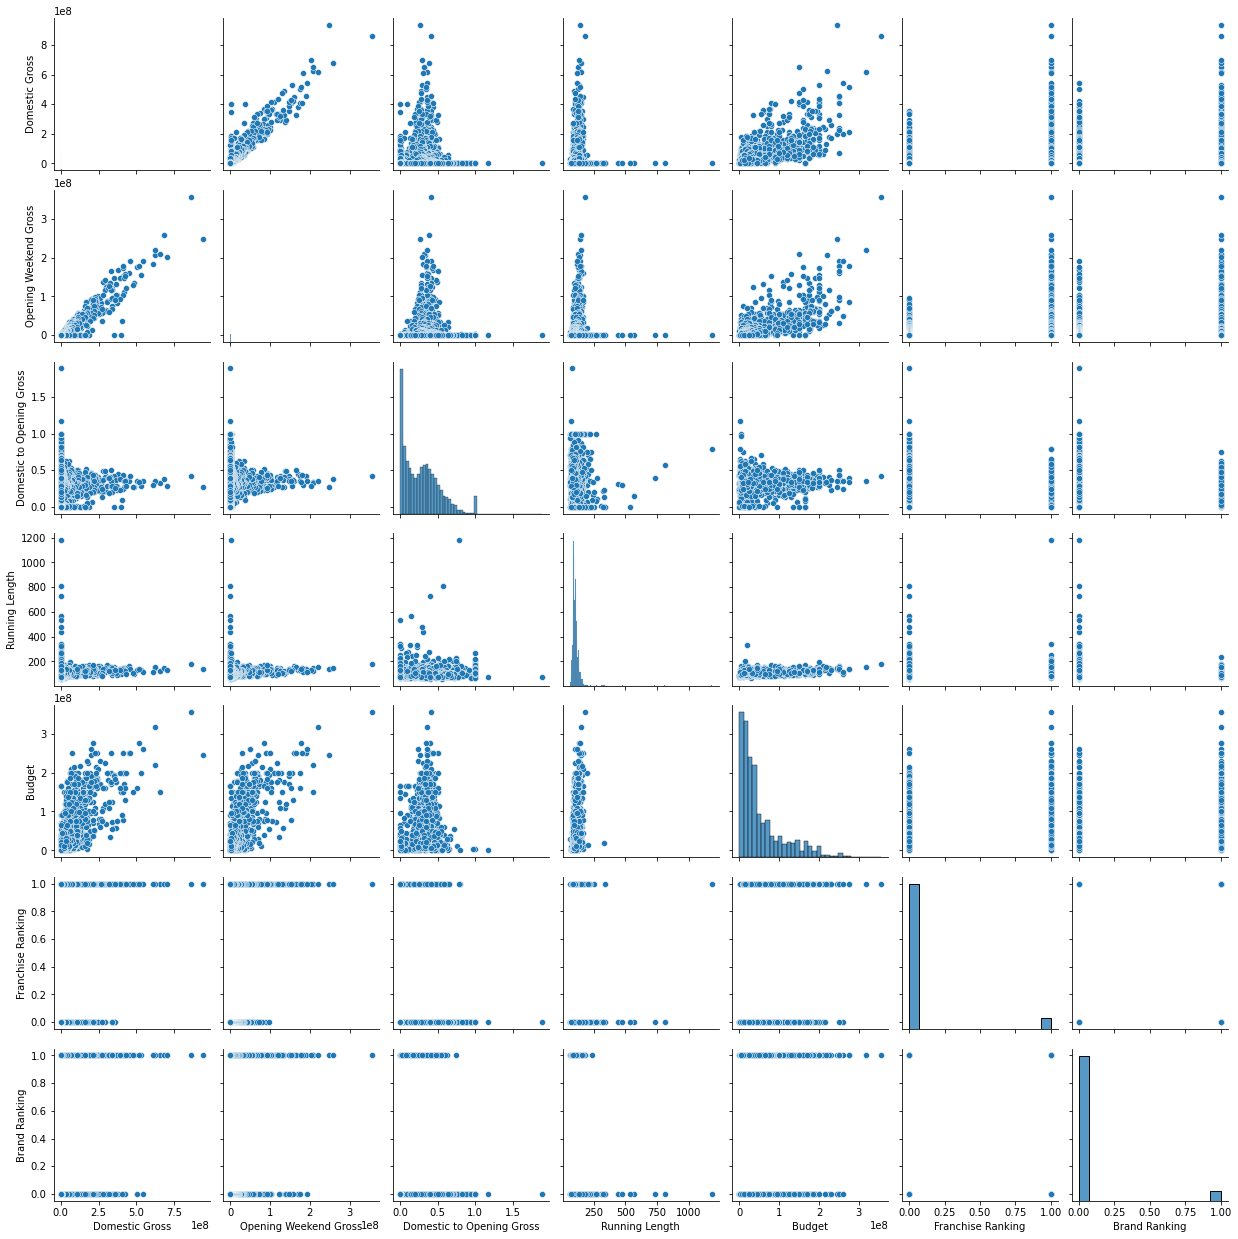

In [311]:
sns.pairplot(df_movies)

/home/navish/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Budget'>

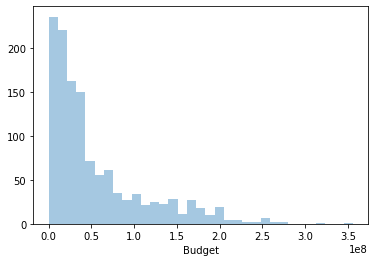

In [23]:
sns.distplot(df_movies[~df_movies.Budget.isna()].Budget,kde=False)


### Scraping for Budget 

Since the 'Title ID' is the same for a given movie in Box Office Mojo & IMDB, the latter is used to scraped all inidividual movie pages to look for budget values.

In [16]:
def scrape_imdb_title_links(url):
    """
    Function to scrape IMDB's Title Page for a movie.
    Confirm necessary information was retrieved & return HTML format page.
    
    Input: Title Link (url), that has to be queried
    Output: If successful, tuple containing (True,HTML Page)
            If not successful, tuple containing (False, Error message and if possible, the HTML page)
    """
    
    time.sleep(1+2*random.random())
    try:
        
        response = requests.get(url)
        if response.status_code != 200:
            return (False,"Not able to get results from the page. Received status code {}" \
                    .format(response.status_code))
        
        else:
            soup_title = BeautifulSoup(response.text,'html5lib')
            
            try:
                title_block = soup_title.find('div', class_='title_block')
#                 assert title_block
                return (True,soup_title)
            except Exception as error_message:
                return (False,"Asserting title block gave following error: {}\n Soup Results: \n {}".format(error_message,soup_title))
    except Exception as error_message:
        return (False,"Received error message from overall scraping. {}".format(error_message))

In [28]:
#Code to iter over all rows of the dataframe, scrape the respective IMDB page & parse for Budget values 

counter = 1
url = 'https://www.imdb.com/title/{}/'
for row_index,row_series in df_movies[null_values_mask].loc[:,:].iterrows():
    title_id = row_series['Title ID']
    print(url.format(title_id))
    result = scrape_imdb_title_links(url.format(title_id))
    budget = np.nan
    soup_title = ''
    
    if result[0]:
        soup_title = result[1]
        try:
            temp = soup_title.find('div', id='titleDetails'). \
                                     find('h4',text=re.compile('Budget')).next_sibling.strip()
            budget = currency_to_int(temp)
            
        except Exception as error_message:
            print("Error getting the budget from HTML. Message is {}".format(error_message))
        
    else:
        print("Error scraping the link or finding the title summary.")
        print(result[1])
        
    df_movies.loc[row_index,'Budget'] = budget
#     df_imdb_raw.loc[title_id,'HTML'] = soup_title


    counter += 1
    
    if counter%25 == 0:
        df_movies.to_csv("Movies_listv3.csv",index=False)
#         df_imdb_raw.to_csv("HTML_IMDB_RAW.csv",index=False)
        time.sleep(20+5*random.random())

df_movies.to_csv("Movies_listv3.csv",index=False)

In [25]:
df_movies = pd.read_csv("Movies_listv3.csv")

In [26]:
df_movies.Budget.isna().sum()

3854